### Load and Fit

In [1]:
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from modeling import get_data


# load
df, _ = get_data(match_played=2, minutes_played=90)
df = df.set_index("player_id")
X = df.drop(columns=["new_position","position"])
y = df["new_position"]

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# fit
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dim defending shape(3069, 104)
Dim possession shape(3069, 140)
Dim passing shape(3069, 229)
Dim shooting shape(3069, 206)
Dim goal_keeping shape(3069, 96)
Merge shape: (3069, 770)
Apply filters: match_played=2 , minutes_player=90
Config 1 columns: 70
Config 2 columns: 25


RandomForestClassifier(random_state=42)

### Create SHAP Values for each player

In [6]:
X_scaled.shape, X.shape

((2352, 67), (2352, 67))

In [26]:
# Create SHAP explainer
explainer = shap.Explainer(model, X_scaled[:10])

# Compute SHAP values for full data (disable additivity check)
shap_values = explainer(X_scaled, check_additivity=False)

 95%|=================== | 8898/9408 [00:15<00:00]       

__Mean Shap values per Class__

In [ ]:
for class_idx in range(model.n_classes_):
    class_shap = shap_values.values[:, :, class_idx]
    print(f"Mean SHAP for class {class_idx}:")
    print(pd.DataFrame(class_shap, columns=X.columns).mean())

Mean SHAP for class 0:
up_balls_received_successful         0.002798
shots_avg_distance                   0.000452
pressure_on_opponent_middle_third    0.006942
clearance_total                     -0.001404
passes_from_defending_third         -0.004513
                                       ...   
shots_in_middle_third                0.000266
touches_in_defending_third          -0.000998
big_chances_total                   -0.000011
up_shots_short_distance              0.000135
passes_backward_completed            0.000405
Length: 64, dtype: float64
Mean SHAP for class 1:
up_balls_received_successful        -0.001768
shots_avg_distance                  -0.000043
pressure_on_opponent_middle_third    0.000183
clearance_total                      0.001613
passes_from_defending_third          0.003426
                                       ...   
shots_in_middle_third               -0.000319
touches_in_defending_third           0.000329
big_chances_total                   -0.000101
up_shot

### Assign to players their shap value

__Extract the SHAP values only for corresponding true position label__

In [27]:
import numpy as np

# Step 1: Map position labels to class indices
label_to_index = {label: idx for idx, label in enumerate(model.classes_)}  # e.g., {'Defender': 0, ...}
true_class_indices = y.map(label_to_index).values  # shape: (3096,)

# Step 2: Extract SHAP values of the true class for each sample
n_samples, n_features, n_classes = shap_values.values.shape
shap_true_class = np.zeros((n_samples, n_features))

for i in range(n_samples):
    shap_true_class[i] = shap_values.values[i, :, true_class_indices[i]]

# Step 3: Convert to DataFrame
shap_df = pd.DataFrame(shap_true_class, columns=shap_values.feature_names)
shap_df['position'] = y.values
shap_df.index = X.index  # optional, to keep original labels
shap_df

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,position
player_id,,,,,,,,,,,,,,,,,,,,,
2936,0.014757,0.005851,0.002775,0.033956,0.017601,-0.000033,0.020036,0.041692,0.007686,-0.000127,...,0.034421,0.027153,0.004569,0.008528,0.006774,0.004914,0.007989,0.001960,0.001471,Defender
2943,0.002479,0.012017,0.003230,0.037891,0.006381,0.000215,0.012894,0.009817,0.004828,0.007021,...,-0.001342,0.003205,0.000957,0.011950,0.005715,0.000040,0.004729,0.002816,-0.000501,Midfielder
2944,0.003282,0.008893,-0.001263,0.023882,0.034108,0.005887,0.016469,0.044937,0.005068,0.000213,...,0.050020,0.004692,0.002444,0.009618,0.000579,0.001792,-0.000823,0.010898,0.004482,Midfielder
2946,0.014804,0.015970,0.007848,0.033744,0.021161,-0.000067,0.020167,0.034925,0.003775,-0.000746,...,0.046604,0.013772,0.011384,0.011656,0.005411,0.003577,0.005066,0.005433,0.000353,Defender
2947,0.144933,0.008833,0.008333,0.012012,0.004488,0.000000,0.008850,0.020631,0.000000,0.000683,...,0.007606,0.097599,0.000250,0.000061,0.002490,0.005473,0.046980,0.000183,0.001183,Goalkeeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401542,0.005744,-0.000889,0.017879,0.026375,0.047894,0.002776,0.021590,0.039866,0.006500,-0.000643,...,0.070924,0.011412,-0.000549,0.014664,-0.001543,0.006115,0.005812,0.000598,0.004989,Forward
401775,0.002541,0.009342,-0.001984,0.033657,0.033019,0.003204,0.016189,0.043729,0.012853,0.004102,...,0.032662,-0.014064,-0.000883,0.009122,0.000926,-0.000504,0.001650,0.008447,-0.002954,Midfielder
402967,0.004577,0.001349,0.013226,0.022882,0.053533,0.001090,0.025417,0.056484,0.003706,0.003871,...,0.062466,0.016915,0.001681,0.007098,-0.000099,0.021665,0.004121,0.003578,0.003197,Forward


### Clustering across positions
1. transform features to 2d using UMAP
2. fit and predict with KMeans clusters
3. plot and evaluate
4. analyze cluster representatives and their SHAP values to understand the cluster

In [28]:
from sklearn.cluster import KMeans
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns


# prepare data
X_shap = shap_df.drop(columns=['position'])
y_shap = shap_df['position']

# 1. Transform features to 2D using UMAP
umap_transformer = UMAP(n_components=2, init='random', random_state=42)
umap_2d_features:np.ndarray = umap_transformer.fit_transform(X_shap)
umap_2d_features

# 2. Fit and predict with KMeans clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  
y_pred = kmeans.fit_predict(umap_2d_features)


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


#### Plot

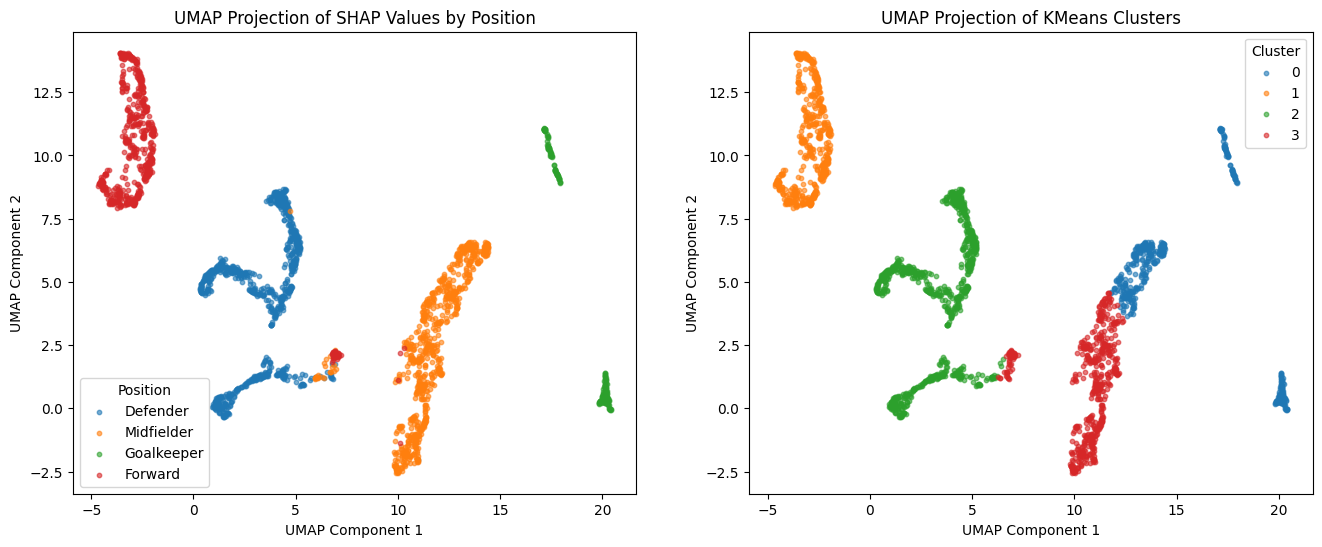

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: UMAP by position
unique_positions = y_shap.unique()
palette = sns.color_palette("tab10", n_colors=len(unique_positions))
position_to_color = {pos: palette[i] for i, pos in enumerate(unique_positions)}

for pos in unique_positions:
    mask = y_shap == pos
    axes[0].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=pos,
        color=position_to_color[pos]
    )
axes[0].set_title('UMAP Projection of SHAP Values by Position')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].legend(title="Position")

# Right: UMAP by KMeans cluster
unique_clusters = np.unique(y_pred)
palette_clusters = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_to_color = {c: palette_clusters[i] for i, c in enumerate(unique_clusters)}

for c in unique_clusters:
    mask = y_pred == c
    axes[1].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=c,
        color=cluster_to_color[c]
    )
axes[1].set_title('UMAP Projection of KMeans Clusters')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].legend(title="Cluster")

#plt.tight_layout()
plt.show()


#### Analysis

__Silhouette Score__
- Measures how similar a point is to its own cluster vs. others. Higher is better.

In [30]:
from sklearn.metrics import silhouette_score

silhouette_score(umap_2d_features, y_pred)

0.5301034

__Top 5 Max/Min Feature Averages per Cluster__

In [12]:
# assign clusters to shap_df for analysis
shap_df["cluster"] = y_pred
cluster_means = shap_df.groupby("cluster").mean(numeric_only=True)

# Analyze each cluster
for cluster_id, row in cluster_means.iterrows():
    print(f"\nCluster {cluster_id}")
    
    # Top 5 features with highest average
    top5_max = row.sort_values(ascending=False).head(5)
    print("  Top 5 max average features:")
    print(top5_max.to_string())

    # Top 5 features with lowest average
    top5_min = row.sort_values(ascending=True).head(5)
    print("  Top 5 min average features:")
    print(top5_min.to_string())


Cluster 0
  Top 5 max average features:
39    0.035168
59    0.034553
7     0.023778
58    0.021663
50    0.018524
  Top 5 min average features:
53    0.000156
11    0.000764
25    0.000872
33    0.001659
12    0.001688

Cluster 1
  Top 5 max average features:
39    0.060617
58    0.042136
17    0.033424
36    0.032652
30    0.027791
  Top 5 min average features:
53    0.000411
25    0.000823
12    0.001496
11    0.001543
28    0.001960

Cluster 2
  Top 5 max average features:
39    0.049673
59    0.043102
50    0.038333
58    0.029020
7     0.028668
  Top 5 min average features:
53    0.000102
38    0.000185
11    0.000259
25    0.000702
12    0.000710

Cluster 3
  Top 5 max average features:
0     0.146343
59    0.091885
49    0.086393
31    0.060619
33    0.052816
  Top 5 min average features:
38    0.000000
25    0.000000
12    0.000000
53    0.000000
21    0.000016


### Clustering within positions
- doesnt work so well currently
fix:
- split by position
- train model to find player role (left wing, right wing etc.)
- then have shap values on that 

c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


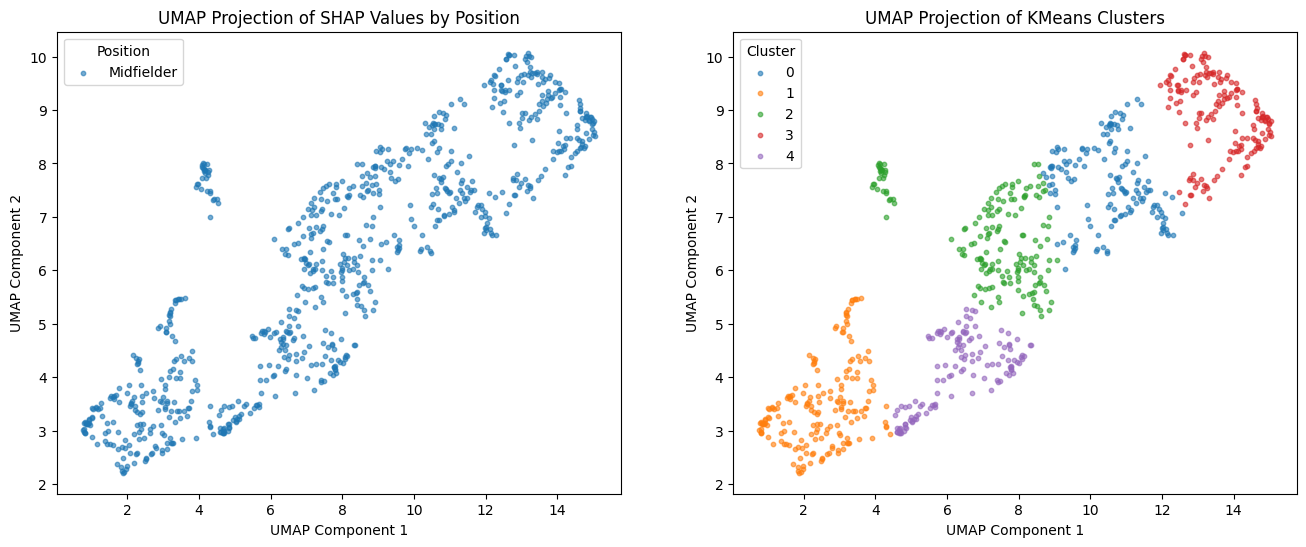

In [13]:
# prepare data
df_midfielder = shap_df[shap_df['position'] == 'Midfielder']
X_shap = df_midfielder.drop(columns=['position'])
y_shap = df_midfielder['position']

# 1. Transform features to 2D using UMAP
umap_transformer = UMAP(n_components=2, init='random', random_state=42)
umap_2d_features:np.ndarray = umap_transformer.fit_transform(X_shap)
umap_2d_features

# 2. Fit and predict with KMeans clusters
kmeans = KMeans(n_clusters=5, random_state=42)  
y_pred = kmeans.fit_predict(umap_2d_features)


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: UMAP by position
unique_positions = y_shap.unique()
palette = sns.color_palette("tab10", n_colors=len(unique_positions))
position_to_color = {pos: palette[i] for i, pos in enumerate(unique_positions)}

for pos in unique_positions:
    mask = y_shap == pos
    axes[0].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=pos,
        color=position_to_color[pos]
    )
axes[0].set_title('UMAP Projection of SHAP Values by Position')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].legend(title="Position")

# Right: UMAP by KMeans cluster
unique_clusters = np.unique(y_pred)
palette_clusters = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_to_color = {c: palette_clusters[i] for i, c in enumerate(unique_clusters)}

for c in unique_clusters:
    mask = y_pred == c
    axes[1].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=c,
        color=cluster_to_color[c]
    )
axes[1].set_title('UMAP Projection of KMeans Clusters')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].legend(title="Cluster")

#plt.tight_layout()
plt.show()


### Clustering Roles

In [2]:
# load data
df_standard_stats = pd.read_csv("../../data/new_approach/standard_stats_all_test.csv")
df_standard_stats = df_standard_stats.set_index("player_id")
df_role = pd.merge(
        left=df,
        right=df_standard_stats[["role"]],
        left_index=True, 
        right_index=True
    )

# split
X = df_role.drop(columns=["new_position","position", "role"])
y = df_role["role"]

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# fit
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

# Create SHAP explainer
explainer = shap.Explainer(model, X_scaled)

# Compute SHAP values for full data (disable additivity check)
shap_values = explainer(X_scaled, check_additivity=False)

100%|===================| 56432/56448 [35:13<00:00]        

In [3]:
import numpy as np

# Step 1: Map position labels to class indices
label_to_index = {label: idx for idx, label in enumerate(model.classes_)}  # e.g., {'Defender': 0, ...}
true_class_indices = y.map(label_to_index).values  # shape: (3096,)

# Step 2: Extract SHAP values of the true class for each sample
n_samples, n_features, n_classes = shap_values.values.shape
shap_true_class = np.zeros((n_samples, n_features))

for i in range(n_samples):
    shap_true_class[i] = shap_values.values[i, :, true_class_indices[i]]

# Step 3: Convert to DataFrame
shap_df = pd.DataFrame(shap_true_class, columns=shap_values.feature_names)
shap_df['role'] = y.values
shap_df.index = X.index  # optional, to keep original labels
shap_df

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,role
player_id,,,,,,,,,,,,,,,,,,,,,
2936.0,0.041663,0.000752,0.012558,0.001984,0.005060,0.007647,0.012199,0.011550,0.003349,-0.000768,...,0.009008,0.002979,0.009040,0.003283,0.005147,0.009945,0.051061,0.004989,0.017154,Right Center Back
2943.0,0.023589,0.018797,0.009599,0.002501,0.003679,0.007471,0.005364,0.014430,0.009157,0.000818,...,0.007316,0.014056,0.006473,0.001069,0.005318,0.002833,0.013875,0.001439,0.020852,Right Wing
2944.0,0.027962,0.006143,0.013798,0.013096,0.007257,0.008021,0.005735,0.010760,0.005503,0.000898,...,0.009465,0.008133,0.012772,0.001060,0.006792,0.004285,0.008762,0.001112,0.013876,Center Forward
2946.0,0.033795,0.009650,0.014228,0.002264,0.005088,0.008770,0.014278,0.018431,0.010154,-0.000223,...,0.012775,0.006936,0.005716,0.002388,0.006449,-0.000551,0.026267,0.002533,0.018244,Right Back
2947.0,0.021723,0.000579,0.010520,0.001069,0.001098,0.009638,0.033513,0.079512,0.000630,0.000001,...,0.066836,0.043425,-0.003630,0.068167,0.001318,0.000122,0.007395,0.089168,0.022584,Goalkeeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401542.0,0.037127,0.010943,0.016470,0.006189,0.011945,0.012994,0.006648,0.008253,0.011034,0.006863,...,0.020933,0.006168,0.013078,0.001067,0.009640,0.001584,0.022198,0.002044,0.010131,Left Midfield
401775.0,0.017273,0.008062,0.010470,0.010954,0.001266,0.009992,0.003002,0.006768,0.009345,0.001918,...,0.010464,0.007855,0.010940,0.001856,0.015826,0.001117,0.016464,0.001925,0.013675,Left Defensive Midfield
402967.0,0.016954,0.009031,0.024447,0.009941,0.005231,0.009813,0.007716,0.010408,0.004389,0.000954,...,0.009430,0.011033,0.010357,0.001996,0.008662,0.009513,0.022184,0.001353,0.007342,Right Midfield


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


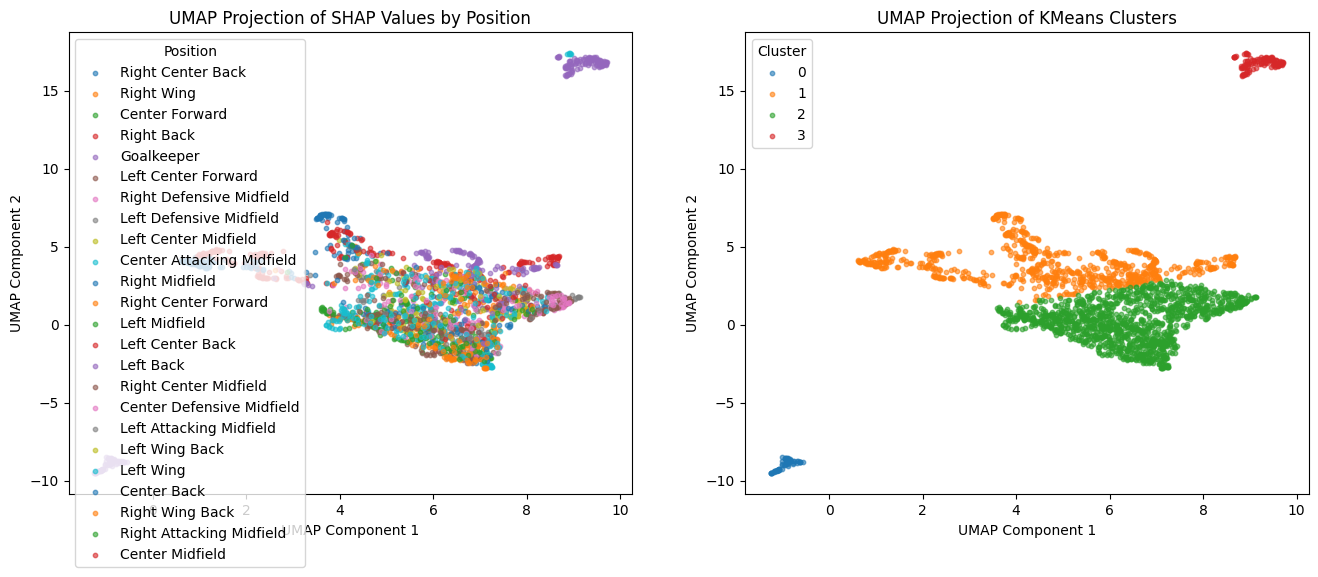

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
import seaborn as sns


# prepare data
X_shap = shap_df.drop(columns=['role'])
y_shap = shap_df['role']

# 1. Transform features to 2D using UMAP
umap_transformer = UMAP(n_components=2, init='random', random_state=42)
umap_2d_features:np.ndarray = umap_transformer.fit_transform(X_shap)
umap_2d_features

# 2. Fit and predict with KMeans clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  
y_pred = kmeans.fit_predict(umap_2d_features)


fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# Left: UMAP by position
unique_positions = y_shap.unique()
palette = sns.color_palette("tab10", n_colors=len(unique_positions))
position_to_color = {pos: palette[i] for i, pos in enumerate(unique_positions)}

for pos in unique_positions:
    mask = y_shap == pos
    axes[0].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=pos,
        color=position_to_color[pos]
    )
axes[0].set_title('UMAP Projection of SHAP Values by Position')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].legend(title="Position")

# Right: UMAP by KMeans cluster
unique_clusters = np.unique(y_pred)
palette_clusters = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_to_color = {c: palette_clusters[i] for i, c in enumerate(unique_clusters)}

for c in unique_clusters:
    mask = y_pred == c
    axes[1].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=c,
        color=cluster_to_color[c]
    )
axes[1].set_title('UMAP Projection of KMeans Clusters')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].legend(title="Cluster")

#plt.tight_layout()
plt.show()


In [ ]:
df_shap_position_role = pd.merge(
        left=shap_df,
        right=df_standard_stats[["new_position"]],
        left_index=True, 
        right_index=True
    )
df_shap_position_role

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,role,new_position
player_id,,,,,,,,,,,,,,,,,,,,,
2936.0,0.041663,0.000752,0.012558,0.001984,0.005060,0.007647,0.012199,0.011550,0.003349,-0.000768,...,0.002979,0.009040,0.003283,0.005147,0.009945,0.051061,0.004989,0.017154,Right Center Back,Defender
2943.0,0.023589,0.018797,0.009599,0.002501,0.003679,0.007471,0.005364,0.014430,0.009157,0.000818,...,0.014056,0.006473,0.001069,0.005318,0.002833,0.013875,0.001439,0.020852,Right Wing,Midfielder
2944.0,0.027962,0.006143,0.013798,0.013096,0.007257,0.008021,0.005735,0.010760,0.005503,0.000898,...,0.008133,0.012772,0.001060,0.006792,0.004285,0.008762,0.001112,0.013876,Center Forward,Midfielder
2946.0,0.033795,0.009650,0.014228,0.002264,0.005088,0.008770,0.014278,0.018431,0.010154,-0.000223,...,0.006936,0.005716,0.002388,0.006449,-0.000551,0.026267,0.002533,0.018244,Right Back,Defender
2947.0,0.021723,0.000579,0.010520,0.001069,0.001098,0.009638,0.033513,0.079512,0.000630,0.000001,...,0.043425,-0.003630,0.068167,0.001318,0.000122,0.007395,0.089168,0.022584,Goalkeeper,Goalkeeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401542.0,0.037127,0.010943,0.016470,0.006189,0.011945,0.012994,0.006648,0.008253,0.011034,0.006863,...,0.006168,0.013078,0.001067,0.009640,0.001584,0.022198,0.002044,0.010131,Left Midfield,Forward
401775.0,0.017273,0.008062,0.010470,0.010954,0.001266,0.009992,0.003002,0.006768,0.009345,0.001918,...,0.007855,0.010940,0.001856,0.015826,0.001117,0.016464,0.001925,0.013675,Left Defensive Midfield,Midfielder
402967.0,0.016954,0.009031,0.024447,0.009941,0.005231,0.009813,0.007716,0.010408,0.004389,0.000954,...,0.011033,0.010357,0.001996,0.008662,0.009513,0.022184,0.001353,0.007342,Right Midfield,Forward


c:\Users\Alexander Lorenz\anaconda3\envs\aifc\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


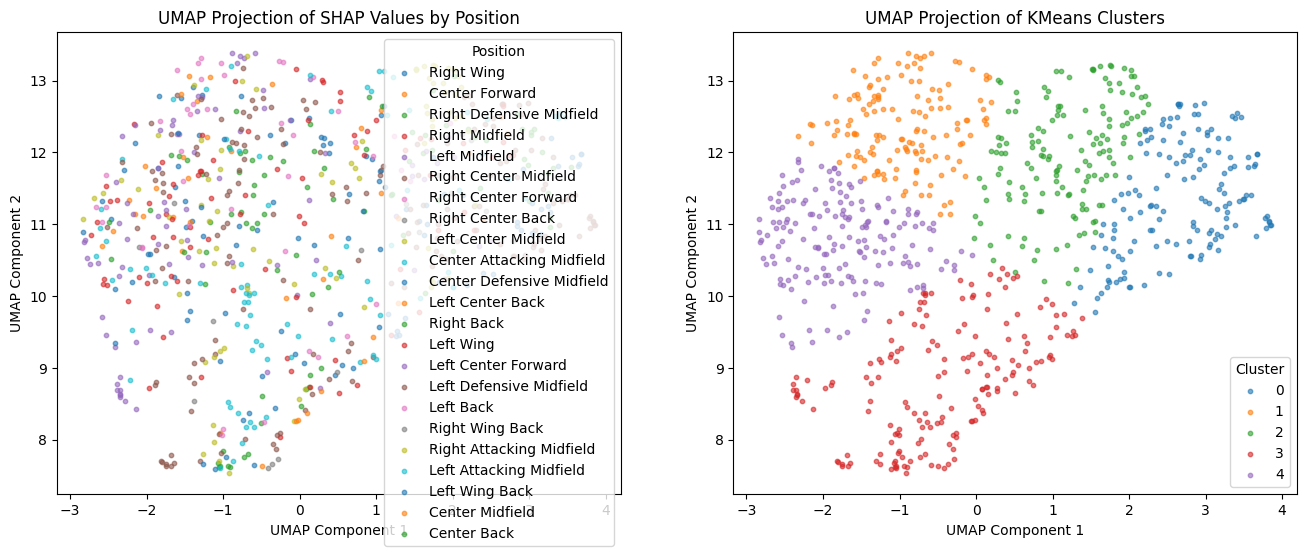

In [12]:
# prepare data
df_midfielder = df_shap_position_role[df_shap_position_role['new_position'] == 'Midfielder']
X_shap = df_midfielder.drop(columns=['new_position','role'])
y_shap = df_midfielder['role']

# 1. Transform features to 2D using UMAP
umap_transformer = UMAP(n_components=2, init='random', random_state=42)
umap_2d_features:np.ndarray = umap_transformer.fit_transform(X_shap)
umap_2d_features

# 2. Fit and predict with KMeans clusters
kmeans = KMeans(n_clusters=5, random_state=42)  
y_pred = kmeans.fit_predict(umap_2d_features)


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: UMAP by position
unique_positions = y_shap.unique()
palette = sns.color_palette("tab10", n_colors=len(unique_positions))
position_to_color = {pos: palette[i] for i, pos in enumerate(unique_positions)}

for pos in unique_positions:
    mask = y_shap == pos
    axes[0].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=pos,
        color=position_to_color[pos]
    )
axes[0].set_title('UMAP Projection of SHAP Values by Position')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
axes[0].legend(title="Position")

# Right: UMAP by KMeans cluster
unique_clusters = np.unique(y_pred)
palette_clusters = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_to_color = {c: palette_clusters[i] for i, c in enumerate(unique_clusters)}

for c in unique_clusters:
    mask = y_pred == c
    axes[1].scatter(
        umap_2d_features[mask, 0],
        umap_2d_features[mask, 1],
        s=10,
        alpha=0.6,
        label=c,
        color=cluster_to_color[c]
    )
axes[1].set_title('UMAP Projection of KMeans Clusters')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')
axes[1].legend(title="Cluster")

#plt.tight_layout()
plt.show()
